2 tensor(2.1672)
4 tensor(1.9605)
6 tensor(1.7906)
8 tensor(1.6222)
10 tensor(1.4571)
12 tensor(1.3131)
14 tensor(1.1973)
16 tensor(1.1011)
18 tensor(1.0166)
20 tensor(0.9543)


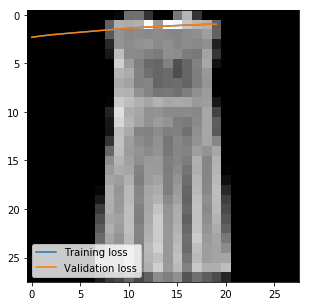

In [3]:
# importing the libraries
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# loading dataset
train = pd.read_csv('train_LbELtWX/train.csv')
test = pd.read_csv('test_ScVgIM0/test.csv')

sample_submission = pd.read_csv('sample_submission_I5njJSF.csv')

train.head()


# random number generator
seed = 128
rng = np.random.RandomState(seed)

# print an image
img_name = rng.choice(train['id'])

filepath = 'train_LbELtWX/train/' + str(img_name) + '.png'

img = imread(filepath, as_gray=True)
img = img.astype('float32')

plt.figure(figsize=(5,5))
plt.imshow(img, cmap='gray')


# loading training images
train_img = []
for img_name in train['id']:
    image_path = 'train_LbELtWX/train/' + str(img_name) + '.png'
    img = imread(image_path, as_gray=True)
    img = img.astype('float32')
    train_img.append(img)

train_x = np.array(train_img)
train_x.shape

train_x = train_x/train_x.max()
train_x = train_x.reshape(-1, 28*28).astype('float32')
train_x.shape

train_y = train['label'].values


# create validation set
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size = 0.1, stratify = train_y)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential
from torch.optim import Adam


# number of neurons in each layer
input_num_units = 28*28
hidden_num_units = 500
output_num_units = 10

# set remaining variables
epochs = 20
learning_rate = 0.0005

# define model
model = Sequential(Linear(input_num_units, hidden_num_units),
                   ReLU(),
                   Linear(hidden_num_units, output_num_units))
# loss function
loss_fn = CrossEntropyLoss()

# define optimization algorithm
optimizer = Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []
for epoch in range(epochs):
    avg_cost = 0
    
    x, y = Variable(torch.from_numpy(train_x)), Variable(torch.from_numpy(train_y), requires_grad=False)
    x_val, y_val = Variable(torch.from_numpy(val_x)), Variable(torch.from_numpy(val_y), requires_grad=False)
    pred = model(x)
    pred_val = model(x_val)

    # get loss
    loss = loss_fn(pred, y)
    loss_val = loss_fn(pred_val, y_val)
    train_losses.append(loss)
    val_losses.append(loss_val)

    # perform backpropagation
    loss.backward()
    optimizer.step()
    avg_cost = avg_cost + loss.data

    if (epoch%2 != 0):
        print(epoch+1, avg_cost)
        
# plotting the training and validation loss
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend()
plt.show()

# get training accuracy
x, y = Variable(torch.from_numpy(train_x)), Variable(torch.from_numpy(train_y), requires_grad=False)
pred = model(x)

final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(train_y, final_pred)

# get validation accuracy
x, y = Variable(torch.from_numpy(val_x)), Variable(torch.from_numpy(val_y), requires_grad=False)
pred = model(x)
final_pred = np.argmax(pred.data.numpy(), axis=1)

accuracy_score(val_y, final_pred)

# loading test images
test_img = []
for img_name in test['id']:
    image_path = 'test_ScVgIM0/test/' + str(img_name) + '.png'
    img = imread(image_path, as_gray=True)
    img = img.astype('float32')
    test_img.append(img)

test_x = np.array(test_img)
test_x.shape


# converting the images to 1-D
test_x = test_x/train_x.max()
test_x = test_x.reshape(-1, 28*28).astype('float32')
test_x.shape


# getting the prediction for test images
prediction = np.argmax(model(torch.from_numpy(test_x)).data.numpy(), axis=1)

# first five rows of sample submission file
sample_submission.head()

# replacing the label with prediction
sample_submission['label'] = prediction
sample_submission.head()


# saving the file
sample_submission.to_csv('submission.csv', index=False)